# Neural Network implementation

### Step 1) *Data prep as described [Here](http://localhost:8888/files/Desktop/Tesi%20Borri/Data%20preparation.ipynb?_xsrf=2%7Ce5b511d0%7C653ab010e3f3fffbd39d614750c07f88%7C1598287506)*

In [2]:
#Importing Libraries and csv

import pandas as pd
import numpy as np
import sympy as sy
import scipy.stats as si
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

ds=pd.read_csv('c:/L3_options_20190815.csv')

#Deleting the unused columns

ds.drop('Volume', axis=1, inplace=True)
ds.drop('OpenInterest', axis=1, inplace=True)
ds.drop('T1OpenInterest', axis=1, inplace=True)
ds.drop('IVBid', axis=1, inplace=True)
ds.drop('IVAsk', axis=1, inplace=True)
ds.drop('AKA', axis=1, inplace=True)
ds.drop('UnderlyingSymbol', axis=1, inplace=True)
ds.drop('Flags', axis=1, inplace=True)

#Creating the target variable 'Price' as the average of Bid and Ask price

ds['Average Price']=(ds['Bid']+ds['Ask'])/2

ds.drop('Bid', axis=1, inplace=True)
ds.drop('Ask', axis=1, inplace=True)

#Creating the variable 'Time to maturity' as a fraction of 252 yearly working days

date_format = "%m/%d/%Y"
ds['StartDay'] = pd.to_datetime(ds[' DataDate']).sub(pd.Timestamp('2019-01-01')).dt.days
ds['ExpirationDay'] = pd.to_datetime(ds['Expiration']).sub(pd.Timestamp('2019-01-01')).dt.days
ds['TimeToMaturity'] = (ds['ExpirationDay'] - ds['StartDay'])/252



#Risk Free rate, the US 3 months treasury bill rate

rf = 0.0187 

ds.drop('Expiration', axis=1, inplace=True)
ds.drop(' DataDate', axis=1, inplace=True)
ds.drop('Last', axis=1, inplace=True)
ds.drop('Delta', axis=1, inplace=True)
ds.drop('Gamma', axis=1, inplace=True)
ds.drop('Theta', axis=1, inplace=True)
ds.drop('Vega', axis=1, inplace=True)
ds.drop('StartDay', axis=1, inplace=True)
ds.drop('ExpirationDay', axis=1, inplace=True)
ds.drop('OptionSymbol', axis=1, inplace=True)

ds['Type_code']=np.where(ds['Type']=='call', 1, 0)

ds.drop('Type', axis=1, inplace=True)

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

train_ds = ds.sample(frac=0.8,random_state=0)
test_ds = ds.drop(train_ds.index)

train_labels = train_ds.pop('Average Price')
test_labels = test_ds.pop('Average Price')

train_ds

,UnderlyingPrice,Strike,IVMean,TimeToMaturity,Type_code
325761,18.39,20.0,0.3999,0.087302,1
171503,86.38,80.0,0.3596,0.503968,0
271864,67.36,78.0,1.2757,0.003968,1
31036,174.37,110.0,0.6132,0.615079,1
837495,121.21,141.0,0.1411,0.503968,0
...,...,...,...,...,...
421004,194.89,178.0,0.3188,0.142857,0
540640,8.87,7.5,0.3803,0.031746,0
712018,253.17,180.0,0.2800,0.170635,1
371456,23.18,24.0,0.5673,0.142857,0


### Step 2) *Normalization of data*

In [4]:
train_stats = train_ds.describe()
train_stats = train_stats.transpose()

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_ds)
normed_test_data = norm(test_ds)

normed_train_data

,UnderlyingPrice,Strike,IVMean,TimeToMaturity,Type_code
325761,-0.294542,-0.293416,-0.216235,-0.597213,0.999713
171503,-0.203835,-0.211376,-0.230967,0.191427,-1.000286
271864,-0.229210,-0.214110,0.103908,-0.754941,0.999713
31036,-0.086446,-0.170355,-0.138265,0.401731,0.999713
837495,-0.157367,-0.127967,-0.310838,0.191427,-1.000286
...,...,...,...,...,...
421004,-0.059069,-0.077376,-0.245881,-0.492061,-1.000286
540640,-0.307243,-0.310508,-0.223400,-0.702365,-1.000286
712018,0.018683,-0.074641,-0.260064,-0.439485,0.999713
371456,-0.288151,-0.287947,-0.155043,-0.492061,-1.000286


### Step 3) *Building the NN*

In [5]:
def NN_model(): 
    model = keras.Sequential([ 
    layers.Dense(64, activation='linear', input_shape=[len(train_ds.keys())]), 
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='relu')
    ]) 
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.004)
    
    model.compile(loss='mae', 
                  optimizer=optimizer, 
                  metrics=['mae']) 
    return model

model=NN_model()

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


### Step 4) *Apply the NN*

In [6]:
EPOCHS =55

tf.debugging.set_log_device_placement(True)

with tf.device('/device:GPU:0'): 
    start = time.time()
    history = model.fit(normed_train_data, train_labels, batch_size=128, epochs=EPOCHS, validation_split = 0.2, verbose=0) 
    end = time.time()


hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch

print("Runtime: " + str(end - start))

hist

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1

Runtime: 546.8086302280426


,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
0,4.844108,4.844113,2.489132,2.489132,0
1,2.433869,2.433867,2.482110,2.482109,1
2,2.053586,2.053586,2.059385,2.059386,2
3,1.815831,1.815830,1.799313,1.799312,3
4,1.670303,1.670301,1.484762,1.484764,4
5,1.507124,1.507123,1.853461,1.853463,5
6,1.438314,1.438313,1.378866,1.378866,6
7,1.335800,1.335800,1.025478,1.025478,7
8,1.293540,1.293541,1.112314,1.112314,8
9,1.229164,1.229164,1.181129,1.181129,9


### Step 5) *Visualizations and evaluation*

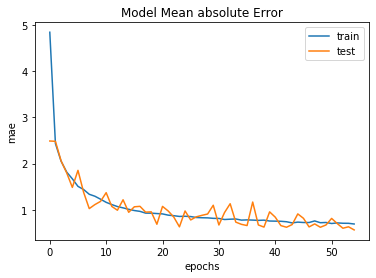

In [7]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean absolute Error')
plt.ylabel('mae')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

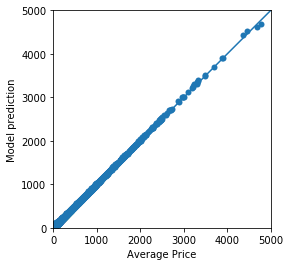

In [8]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, linewidths=0.001)
plt.xlabel('Average Price')
plt.ylabel('Model prediction')
lims = [0, 5000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [9]:
start = time.time()

loss, mae = model.evaluate(normed_test_data, test_labels, verbose=2)

end = time.time()

print("MAE: {:5.10f} ".format(mae))

print("Runtime: " + str(end - start))

185735/185735 - 6s - loss: 0.5576 - mean_absolute_error: 0.5576
MAE: 0.5576096773 
Runtime: 5.735662937164307
